# Building the Validation Set and Baseline Models

- Uniform distribution
- Normal distribution

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Set the directory where the data is loaded.
local_dir = '/content/gdrive/MyDrive/Meli Data Challenge/'

In [6]:
df = pd.read_csv(f'{local_dir}df_sample.csv')

1. Make a temporary split

In [9]:
df.date = pd.to_datetime(df.date)

In [11]:
# separate the last 30 days for validation.
val_data = df.loc[(df.date > '2021-03-01')]

# use the rest as training.
train = df.loc[(df.date <= '2021-03-01')]

2. Create validation dataset by calculating target stock and inventory days

In [49]:
def create_validation_set(dataset):
  np.random.seed(10)
  print('Sorting records...')
  temp_pd = dataset.loc[:, ['sku', 'date', 'sold_quantity']].sort_values(['sku', 'date'])
  print('Grouping quantity...')
  temp_dict = temp_pd.groupby('sku').agg({'sold_quantity': lambda x: [i for i in x]})['sold_quantity'].to_dict()
  result = []
  for idx, list_quantity in tqdm(temp_dict.items(), desc='Making targets...'):
    cumsum = np.array(list_quantity).cumsum()

    stock_target = 0
    if cumsum[-1] > 0:

      # choose a random target different from 0
      while stock_target == 0:
        stock_target = np.random.choice(cumsum)

        # get the first day with this amount of sales
        day_to_stockout = np.argwhere(cumsum==stock_target).min() + 1

        # add to a list
        result.append({'sku': idx,
                       'target_stock': stock_target,
                       'inventory_days': day_to_stockout 
                       })
  return result

# generate target for the 30 days of validation
val = create_validation_set(val_data)

Sorting records...
Grouping quantity...


Making targets...: 100%|██████████| 628883/628883 [00:17<00:00, 35215.25it/s]


In [50]:
val[:10]

[{'inventory_days': 2, 'sku': 1, 'target_stock': 1},
 {'inventory_days': 2, 'sku': 4, 'target_stock': 1},
 {'inventory_days': 1, 'sku': 5, 'target_stock': 2},
 {'inventory_days': 1, 'sku': 6, 'target_stock': 0},
 {'inventory_days': 2, 'sku': 6, 'target_stock': 1},
 {'inventory_days': 1, 'sku': 7, 'target_stock': 11},
 {'inventory_days': 1, 'sku': 9, 'target_stock': 1},
 {'inventory_days': 1, 'sku': 13, 'target_stock': 0},
 {'inventory_days': 1, 'sku': 13, 'target_stock': 0},
 {'inventory_days': 1, 'sku': 13, 'target_stock': 0}]

### Uniform Distribution Model

In [51]:
days_to_predict = 30

In [52]:
y_pred_uniform = [(np.ones(days_to_predict)/days_to_predict).round(4).tolist()] * len(val)

This is how a uniform distribution baseline output would look like.

In [53]:
pd.DataFrame(y_pred_uniform, columns=range(1, days_to_predict+1)).head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333
1,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333
2,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333
3,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333
4,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333,0.0333


## Scoring Function

In [66]:
def ranked_probability_score(y_true, y_pred):
  return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
  """
  Input
    y_true: List of ints of shape Nx1. Contain the target_stock
    y_pred: List of float of shape Nx30. Contain the prob each day
  """
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  y_true_one_hot = np.zeros_like(y_pred, dtype=np.float)
  y_true_one_hot[range(len(y_true)), y_true-1] = 1
  return ranked_probability_score(y_true_one_hot, y_pred)

In [67]:
y_true_val = [x['inventory_days'] for x in val]

In [68]:
y_true_val[:10]

[2, 2, 1, 1, 2, 1, 1, 1, 1, 1]

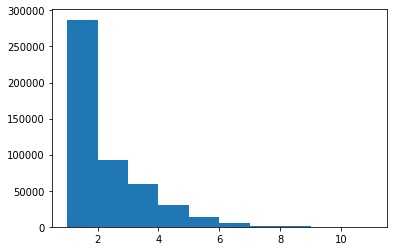

In [73]:
import matplotlib.pyplot as plt
plt.hist(y_true_val)

plt.show()

In [78]:
max(y_true_val)

11

In [69]:
uniform_score = scoring_function(y_true_val, y_pred_uniform)
print('Uniform model got a validation RPS of: ', uniform_score)

Uniform model got a validation RPS of:  8.809584030352854
